1. 패키지 임포트

In [16]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

#statsmodels 패키지 로지스틱회귀
from statsmodels.formula.api import logit
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score

# sklearn 패키지 로지스틱 회귀
from sklearn.linear_model import LogisticRegression

In [2]:
plt.rcParams['font.family'] == 'Malgun Gothic'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['axes.unicode_minus'] = False

2. 데이터 불러오기

|변수|구분|설명|
|---|---|---|
|합격여부|범주형|1=합격, 0=불합격|
|필기점수|연속형|800점 만점|
|학부성적|연속형|4.0만점|
|병원경력|범주형|1:10년이상, 2:2~5년, 3:1~5년, 4:1년 미만|

In [4]:
df = pd.read_excel('https://data.hossam.kr/E05/gradeuate.xlsx')
df.head()

,합격여부,필기점수,학부성적,병원경력
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


> X(필기점수, 학부성적, 병원경력) / Y(합격여부)

## Statsmodels 패키지 (표준화 X)
3. 로지스틱회귀 분석 실시

In [6]:
df1 = df.copy()

# 객체 생성
model = logit('합격여부 ~ 필기점수+학부성적+병원경력', data=df1)
# 훈련시키기
fit = model.fit()
# 분석결과 보기
print(fit.summary())

Optimization terminated successfully.
         Current function value: 0.574302
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   합격여부   No. Observations:                  400
Model:                          Logit   Df Residuals:                      396
Method:                           MLE   Df Model:                            3
Date:                Thu, 21 Sep 2023   Pseudo R-squ.:                 0.08107
Time:                        09:07:16   Log-Likelihood:                -229.72
converged:                       True   LL-Null:                       -249.99
Covariance Type:            nonrobust   LLR p-value:                 8.207e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.4495      1.133     -3.045      0.002      -5.670      -1.229
필기점수           0.0023      0.

> 결과 해석 : Pseudo R-squ(의사결정계수) = 종속변수의 분산 중 어느 정도의 비율(%)이 독립변수에 의해 설명되는가? 0.08107 <br>
> 회귀식 : $z = 0.0023 x (필기점수) + 0.7770 x (학부성적) -0.5600 x (병원경력) -3.4495

In [17]:
fit.prsquared

0.08107331586891464

In [27]:
coef = fit.params
coef

Intercept   -3.449549
필기점수         0.002294
학부성적         0.777014
병원경력        -0.560031
dtype: float64

4. 예측 결과를 데이터 프레임에 추가

In [8]:
x = df1.drop('합격여부', axis=1)
y = df1['합격여부']

df1['예측값'] = fit.predict(x)
df1['예측결과'] = df1['예측값'] > 0.5
df1['예측결과'] = df1['예측결과'].astype(int)
df1

,합격여부,필기점수,학부성적,병원경력,예측값,예측결과
0,0,380,3.61,3,0.189553,0
1,1,660,3.67,3,0.317781,0
2,1,800,4.00,1,0.717814,1
3,1,640,3.19,4,0.148949,0
4,0,520,2.93,4,0.097954,0
...,...,...,...,...,...,...
395,0,620,4.00,2,0.490176,0
396,0,560,3.04,3,0.184989,0
397,0,460,2.63,2,0.186814,0
398,0,700,3.65,2,0.468108,0


5. 혼동행렬 구하기

In [9]:
cm = confusion_matrix(df1['합격여부'],df1['예측결과'])
cm

array([[253,  20],
       [ 98,  29]], dtype=int64)

|tn|tp|
|--|--|
|fn|fp|

In [12]:
# 혼동행렬 라벨 붙이기
tn, tp, fn, fp = cm.ravel()

In [13]:
# 데이터프레임으로 만들기
cmdf = pd.DataFrame([[tn, tp], [fn,fp]], index=['True','False'], columns=['Negative', 'Positive'])
cmdf

,Negative,Positive
True,253,20
False,98,29


6. ROC Curve 시각화

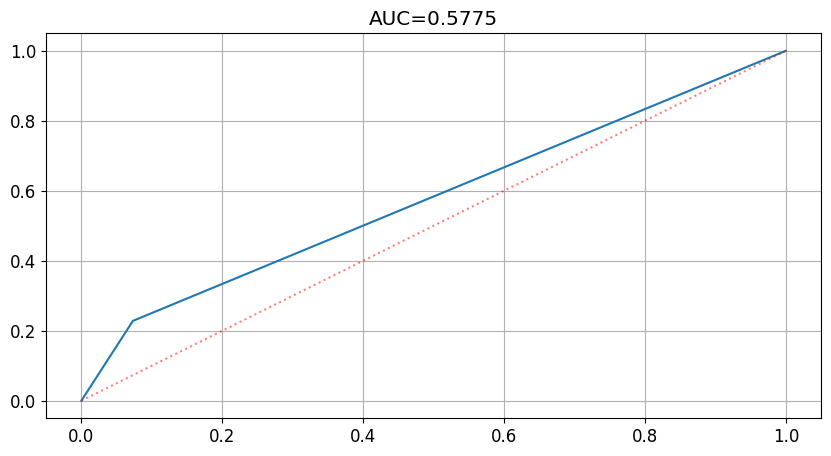

In [15]:
ras = roc_auc_score(df1['합격여부'], df1['예측결과'])

# fpr(=fallout) = fp / tp+fp (실제 Negative인 것 중 잘못 분류한 비율) | tpr(=Recall) = tp / tp+fn(실제 Positive인 것 중 얼마나 정확히 분류했는지)
fpr, tpr, thresholds = roc_curve(df1['합격여부'], df1['예측결과'])

plt.figure()
sb.lineplot(x=fpr, y=tpr)
sb.lineplot(x=[0,1], y=[0,1], color='red', linestyle=':', alpha=0.5)
plt.title('AUC={:.4f}'.format(ras))
plt.grid()
plt.show()
plt.close()

In [20]:
# 정확도
acc = accuracy_score(df1['합격여부'], df1['예측결과'])

# 정밀도
pre = precision_score(df1['합격여부'], df1['예측결과'])

# 재현율
recall = recall_score(df1['합격여부'], df1['예측결과'])

# F1score
f1 = f1_score(df1['합격여부'], df1['예측결과'])

# 위양성율
fpr = fp / tn+fp

# 특이성
spe = 1 - fpr

# 데이터프레임으로 합치기
result_df = pd.DataFrame({'설명력Pseudo R-squ.': [fit.prsquared], '정확도': [acc], '정밀도': [pre], '재현율(TPR)': [recall], 'F1score': [f1], '위양성율(FPR)': [fpr], '특이성(TNR)': [spe]})
result_df.T

,0
설명력Pseudo R-squ.,0.081073
정확도,0.705000
정밀도,0.591837
재현율(TPR),0.228346
F1score,0.329545
위양성율(FPR),29.114625
특이성(TNR),-28.114625


7. 오즈비
= 성공할 확률 / 실패할 확률  

즉, 이 데이터에선 합격할 확률/불합격할 확률 

In [29]:
# coef 회귀계수를 지수함수 적용
odds_rate = np.exp(coef) 
odds_rate_df = pd.DataFrame(odds_rate, columns=['odds_rate'])
odds_rate_df

,odds_rate
Intercept,0.031760
필기점수,1.002297
학부성적,2.174967
병원경력,0.571191


## Statsmodels 표준화O

In [ ]:
from statsmodels.

## Statsmodels 더미변수 처리

*****************

## sklearn 패키지